# importing libraries

!pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

# importing data & pre-processing Step

### importing & describing data 

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()
# the column Name contains some useful informations (mr, mrs, miss, ...)
#we will extract those informations in feature engineering section

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.describe()
# this project aims to predict survived passengers in sinking titanic: survived={1 if survived, 0 if not}
#mean(survived) = 0.38 -> 38% did survive from this titanic sinking

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
data.info()
# features with NA values: age, cabin, embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### filling na values 

In [6]:
#cabin contains 204/891 = 23% available values => filling 77% values manually or automatically will affect our model 
#(depending on how we will fill those values {by mean, median, ...}) 
#it is better to build a ML model without this column
data = data.drop(["Cabin","Ticket"], axis ="columns")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [7]:
#fillin na values for age column
na_values = data["Age"].isnull().sum()
mean = data["Age"].mean()
std = data["Age"].std()
#the idea is to simulate random ages in [mean - std, mean + std]
age_filled = np.random.randint(mean - std, mean + std, size = na_values)
j=0
for i in range(len(data['Age'])):
    if math.isnan(data["Age"][i]) == True:
        data["Age"][i] = age_filled[j]
        j=+1
data['Age'].isnull().sum()

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_17044/3748280319.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Age"][i] = age_filled[j]


0

In [8]:
#filling na values for embarked column
print(data["Embarked"].unique())
print(data["Embarked"].isnull().sum())
data['Embarked'] = data['Embarked'].fillna('NA')
print(data["Embarked"].isnull().sum())
data.head()

['S' 'C' 'Q' nan]
2
0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


### Feature engineering

In [9]:
#Name column
# https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
# extract titles
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data['Title'].unique()
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
# replace titles with a more common title or as other
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr','Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
# convert titles into numbers
data['Title'] = data['Title'].map(titles)
# filling NaN with 0, to get safe
data['Title'] = data['Title'].fillna(0)
data = data.drop(['Name'], axis = 1)
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   Title        891 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 69.7+ KB


In [10]:
gender = {"male": 0, "female": 1}
data['Sex'] = data['Sex'].map(gender)

In [11]:
emb = {"S": 0, "C": 1, "Q": 2, "NA":3}
data['Embarked'] = data['Embarked'].map(emb)
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,0,22.0,1,0,7.2500,0,1.0
1,2,1,1,1,38.0,1,0,71.2833,1,3.0
2,3,1,3,1,26.0,0,0,7.9250,0,2.0
3,4,1,1,1,35.0,1,0,53.1000,0,3.0
4,5,0,3,0,35.0,0,0,8.0500,0,1.0


In [12]:
data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,27.587172,0.523008,0.381594,32.204208,0.368126,1.599327
std,257.353842,0.486592,0.836071,0.477990,13.683054,1.102743,0.806057,49.693429,0.647601,0.919184
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,19.000000,0.000000,0.000000,7.910400,0.000000,1.000000
50%,446.000000,0.000000,3.000000,0.000000,24.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,4.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    int64  
 9   Title        891 non-null    float64
dtypes: float64(3), int64(7)
memory usage: 69.7 KB


In [14]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,0,22.0,1,0,7.2500,0,1.0
1,2,1,1,1,38.0,1,0,71.2833,1,3.0
2,3,1,3,1,26.0,0,0,7.9250,0,2.0
3,4,1,1,1,35.0,1,0,53.1000,0,3.0
4,5,0,3,0,35.0,0,0,8.0500,0,1.0


# ML

### extract train test samples from data

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
x_train = train.drop(['Survived'], axis = 1)
y_train = train['Survived']
x_test = test.drop(['Survived'], axis = 1)
y_test = test['Survived']

In [16]:
print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_test : ', x_test.shape)
print('y_test : ', y_test.shape)

x_train :  (712, 9)
y_train :  (712,)
x_test :  (179, 9)
y_test :  (179,)


In [17]:
x_train.drop(['PassengerId'], axis= 1)
x_test.drop(['PassengerId'], axis= 1)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
709,3,0,19.0,1,1,15.2458,1,4.0
439,2,0,31.0,0,0,10.5000,0,1.0
840,3,0,20.0,0,0,7.9250,0,1.0
720,2,1,6.0,0,1,33.0000,0,2.0
39,3,1,14.0,1,0,11.2417,1,2.0
...,...,...,...,...,...,...,...,...
433,3,0,17.0,0,0,7.1250,0,1.0
773,3,0,19.0,0,0,7.2250,1,1.0
25,3,1,38.0,1,5,31.3875,0,3.0
84,2,1,17.0,0,0,10.5000,0,2.0


In [18]:
# Sur-échantillonnage
rOs = RandomOverSampler(random_state=1)
x_ro, y_ro = rOs.fit_resample(x_train, y_train)

In [19]:
print('avant le réechantillonnage')
print(x_train.shape, y_train.shape)
print('aprés le réechantillonnage')
print(x_ro.shape, y_ro.shape)

avant le réechantillonnage
(712, 9) (712,)
aprés le réechantillonnage
(888, 9) (888,)


In [20]:
y_ro.describe()
#mean = 0.5 = count(C1)/count(C1 U C2) = count(C2)/count(C1 U C2)

count    888.000000
mean       0.500000
std        0.500282
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

### logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression
#For the liblinear and lbfgs solvers set verbose to any positive number for verbosity.
lgisticreg = LogisticRegression(solver='liblinear', penalty='l1', random_state= 1, verbose= 10, l1_ratio = 1)
lgisticreg.fit(x_ro, y_ro)
y_pred = lgisticreg.predict(x_test)
print("score:  ", lgisticreg.score(x_test, y_test)) #mean_accuracy
confusion_matrix(y_test, y_pred)


[LibLinear]score:   0.8156424581005587


C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


array([[86, 19],
       [14, 60]], dtype=int64)

l1 regularized logistic regression solves the following optimization problem:

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <munder>
    <mo data-mjx-texclass="OP" movablelimits="true">min</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>w</mi>
      <mo>,</mo>
      <mi>c</mi>
    </mrow>
  </munder>
  <mo data-mjx-texclass="ORD" fence="false" stretchy="false">&#x2016;</mo>
  <mi>w</mi>
  <msub>
    <mo data-mjx-texclass="ORD" fence="false" stretchy="false">&#x2016;</mo>
    <mn>1</mn>
  </msub>
  <mo>+</mo>
  <mi>C</mi>
  <munderover>
    <mo data-mjx-texclass="OP">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
      <mo>=</mo>
      <mn>1</mn>
    </mrow>
    <mi>n</mi>
  </munderover>
  <mi>log</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mi>exp</mi>
  <mo data-mjx-texclass="NONE">&#x2061;</mo>
  <mo stretchy="false">(</mo>
  <mo>&#x2212;</mo>
  <msub>
    <mi>y</mi>
    <mi>i</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <msubsup>
    <mi>X</mi>
    <mi>i</mi>
    <mi>T</mi>
  </msubsup>
  <mi>w</mi>
  <mo>+</mo>
  <mi>c</mi>
  <mo stretchy="false">)</mo>
  <mo stretchy="false">)</mo>
  <mo>+</mo>
  <mn>1</mn>
  <mo stretchy="false">)</mo>
  <mo>.</mo>
</math>

behavior: Penalize the intercept (bad), Robust to unscaled datasets

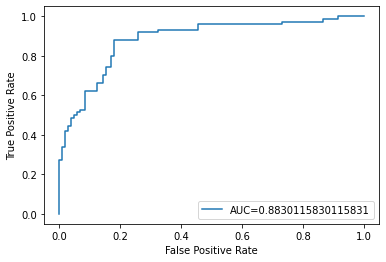

In [25]:
#define metrics
y_pred_proba = lgisticreg.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### decision tree

In [26]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 4)
tree.fit(x_ro, y_ro)
y_pred= tree.predict(x_test)
print("score:  ", tree.score(x_test, y_test))
confusion_matrix(y_test, y_pred)


score:   0.7318435754189944


array([[80, 25],
       [23, 51]], dtype=int64)

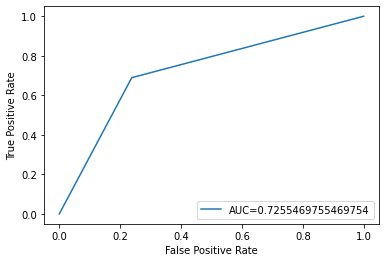

In [27]:
#define metrics
y_pred_proba = tree.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(criterion = "entropy",n_estimators=100, max_features = "log2", oob_score = True, random_state=4, class_weight = "balanced_subsample")
forest.fit(x_train, y_train)
y_pred= forest.predict(x_test)
print("score:  ", forest.score(x_test, y_test))
confusion_matrix(y_test, y_pred)

score:   0.8435754189944135


array([[92, 13],
       [15, 59]], dtype=int64)

fpr, tpr,_ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

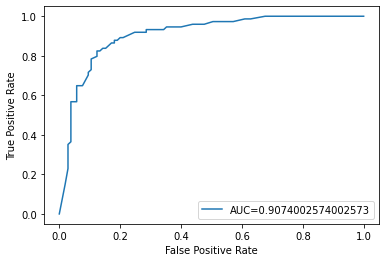

In [29]:
#define metrics
y_pred_proba = forest.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### SVM

In [30]:
cls = {0: -1, 1:1}
y_train_maj = y_ro.map(cls) 
y_test_maj = y_test.map(cls)
y_test_maj.unique()
y_train_maj.unique()

array([-1,  1], dtype=int64)

In [31]:
from sklearn.svm import LinearSVC
svm = LinearSVC(penalty = "l1", dual = False, random_state = 1)
decision_fun = svm.fit(x_ro, y_train_maj).decision_function(x_test)
y_pred = svm.predict(x_test)
print("score:  ", svm.score(x_test, y_test_maj))
confusion_matrix(y_test_maj, y_pred)
len(decision_fun)

score:   0.8156424581005587


179

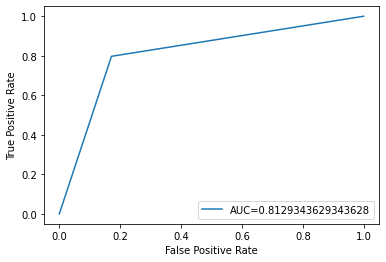

In [32]:
fpr, tpr, _ = roc_curve(y_test_maj, y_pred)
aucc = metrics.auc(fpr, tpr)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(aucc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

### Conclusion: Parmi ces 4 modéles:{logistic regression, decision tree, random forest, Linear SVM} celui qui performe mieux le modéle est Random forest avec un score = 0.84 et AUC = 0.9